## TLDR;

- Linear regression on itself is not performant for longer time-scales
- Most systems have some capabilities for linear regression built-in
- Adding dummy variables for datetime features(i.e. months, weekday etc.) adds predictive power

## Introduction

Linear regrerssion is a statistical model that can be used to determine the linear relationship between variables, most of the time this is seen as a beginners model that is not particularly useful, and most of the time it is discarded and replaced by a shiny neural net or a fancy gradient-boosted model.

the nice feature of linear regression is that the direction and magnitude of the relationship can be estimated with the help of linear regression. It is used in many fields including but not limited to Economics, Finance, Social science, etc. The popularity of this model is model is likely due to the fact that most systems have built-in functionality that enables the training of linear models, they are also very cheap/fast to train, and one can also determine that the model has optimal parameters. all these features make linear regression an excellent model to start with. 

To extend the capabilities of the linear model for time series forecasting, dummy variables can be utilized. These dummies can provide additional information about the relationship over time, can help the model to identify seasonality over time and also gauge the effect of one-off events, examples are price reductions or natural disasters. 

For instance we can create a dummy to identify certain datetime features such as what the month is orwhether a particular day is a weekday or a weekend.

## Imports


In [ ]:
# | echo: false
# | output: false

# importing the black formatter
# and auto format cell before execution
import jupyter_black

jupyter_black.load(lab=False)

First we import all the libraries, the default data science libs and the linear model and metrics from sklearn.

In [ ]:
# | code-fold: show

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [ ]:
# | echo: false
# | output: false
sns.set_style("darkgrid")

In [ ]:
# | echo: false
# | output: false
# setting picture output params

fig_height = 4.0
fig_width = fig_height * 1.618
plt.rcParams["figure.figsize"] = [fig_width, fig_height]
plt.rcParams["figure.dpi"] = 256

## Reading in the data

For this example we will be using a dataset form the prophet package. I have selected this one because in the prophet documentation this dataset is used in the section "Seasonality, Holiday Effects, And Regressors" so it seems fitting to use it, to demonstrate the usefullness of seasonal dummies.
The prophet [docs](https://facebook.github.io/prophet/docs/quick_start.html) describe the dataset in the following way:

> As an example, let’s look at a time series of the log daily page views for the Wikipedia page for Peyton Manning. We scraped this data using the Wikipedia trend package in R. Peyton Manning provides a nice example because it illustrates some of Prophet’s features, like multiple seasonality, changing growth rates, and the ability to model special days (such as Manning’s playoff and superbowl appearances).

In [ ]:
# | code-fold: show

df_in = pd.read_csv(
    "https://raw.githubusercontent.com/facebook/prophet/main/examples/example_wp_log_peyton_manning.csv"
)
df_in = df_in.assign(ds=pd.to_datetime(df_in["ds"]))
df_in = df_in[(df_in["ds"] > "2012")]  # selecting data after 2012

it is always nice to actually see what we are working with so lets plot the data over time to see what we visually can extract from the plot. we are looking for patterns over time, and other behaviour and/or pattern that we can exploit.

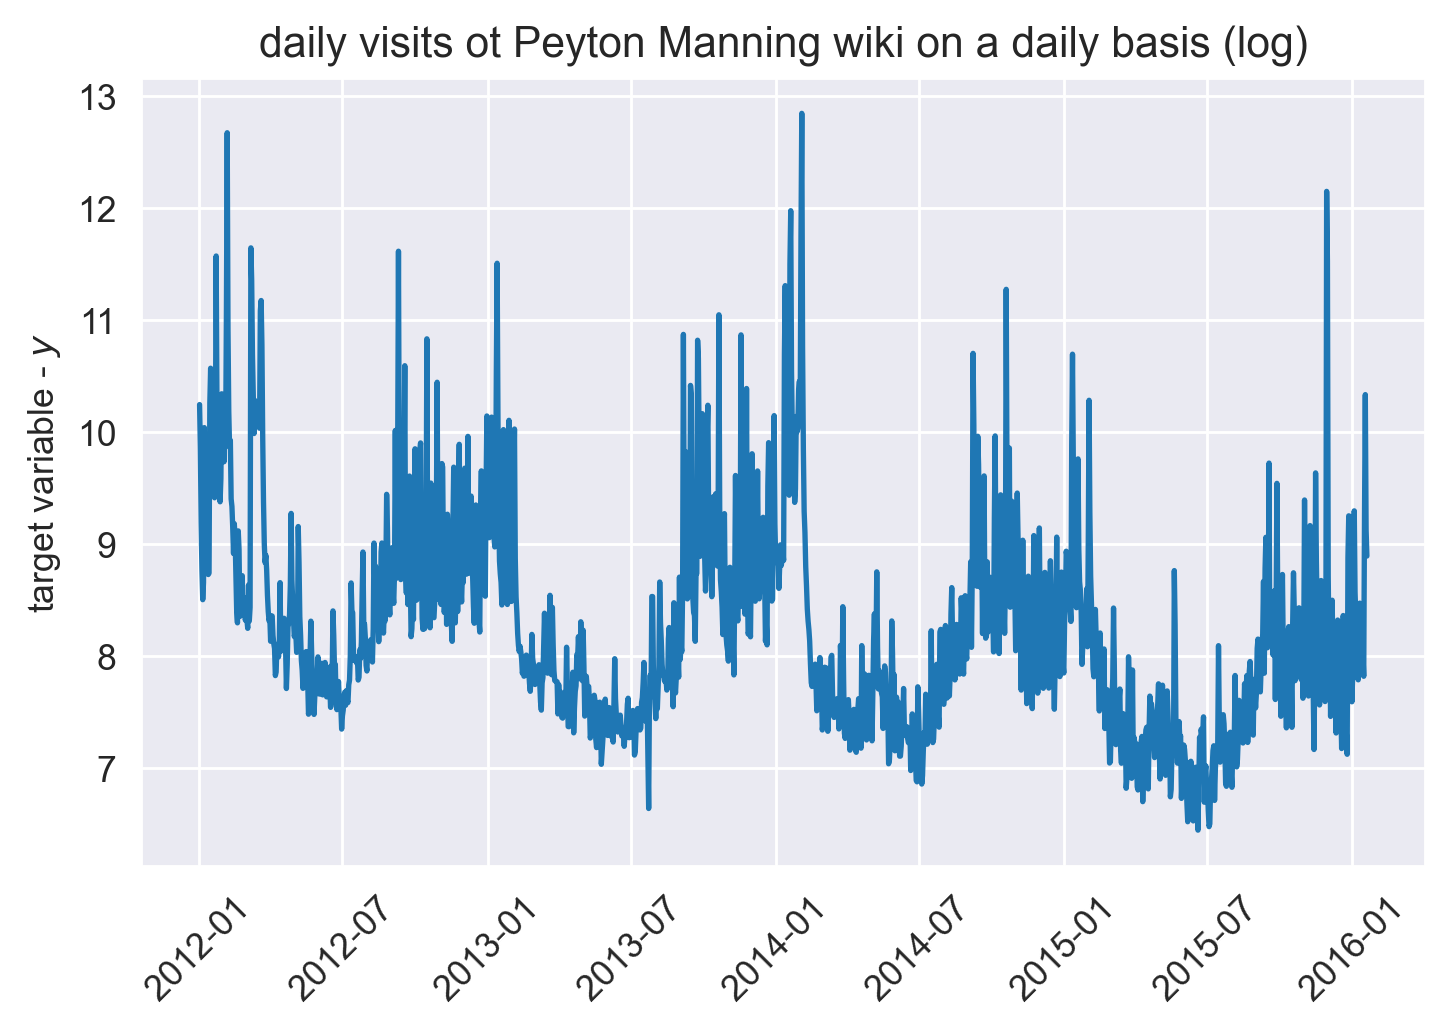

In [ ]:
plt.plot_date(
    x=df_in["ds"],
    y=df_in["y"],
    label="input timeseries",
    fmt="-",
)
plt.tick_params(axis="x", rotation=45)
plt.ylabel("target variable - $y$")
plt.title("daily visits ot Peyton Manning wiki on a daily basis (log)")
plt.show()

I have selected data from 2012 onwards, this should be enough to testdrive the seasonal dummies. The first thing that I notice is that there is a dip around month 06 and 07. Most likely the american football (handegg?)  season is having its summer break then. Also the same pattern repeats over the years start high then dips and then and high again. so there is some repeating seasonality. Lets continue and train our first models. starting with a simple plain linear regression and then adding in the dummies to see if they improve the performance of the model.

## Train-test split

In [ ]:
# train test split
df_train = df_in[(df_in["ds"] > "2012") & (df_in["ds"] < "2015")]
df_test = df_in[(df_in["ds"] > "2015")]

To gauge the performance of the model the data is split in two parts, the train data 2012 onwards up to 2015 and the test data everything after 2015. The model will only see the train data and is asked to create a prediction for the test data, afterwards we will calcualte the perfomance.

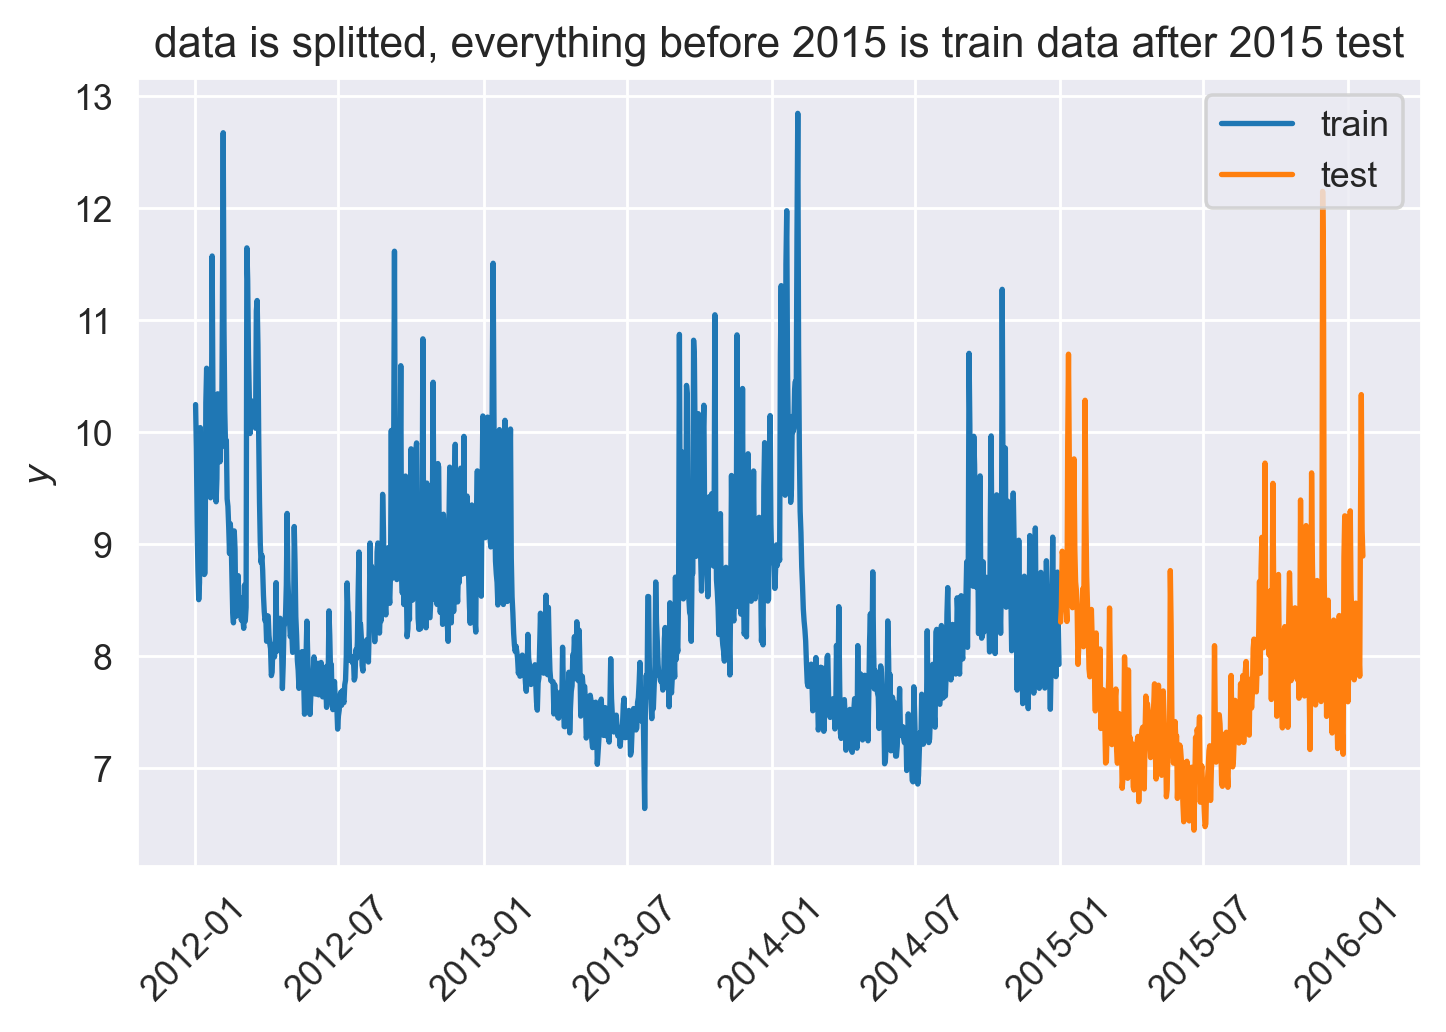

In [ ]:
# visually inspect the train test split
plt.plot_date(
    x=df_train["ds"],
    y=df_train["y"],
    label="train",
    fmt="-",
)
plt.plot_date(
    x=df_test["ds"],
    y=df_test["y"],
    label="test",
    fmt="-",
)
plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("$y$")
plt.title("data is splitted, everything before 2015 is train data after 2015 test")
plt.show()

## Setting up the regression

In [ ]:
X_train = df_train["ds"].astype(int).values.reshape(-1, 1)
y_train = df_train["y"].values

X_test = df_test["ds"].astype(int).values.reshape(-1, 1)
y_test = df_test["y"].values

Shaping and converting the data so that we can fit the linear model. 
In this case we are converting the date into an ever increasing integer.

In [ ]:
# creating, fit, and inference
linear = LinearRegression()
linear.fit(X=X_train, y=y_train)
y_pred = linear.predict(X=X_test)

Fitting the linear model is very fast, around 4 miliseconds on my machine, and yes I know the data volume is very low, but this allows me to fit 1000 models in 4 seconds. so we can make predictions on 1000 things instead of this single item, all in the time it takes to take a sip of coffee☕️.

anyways lets us  visually inspect the results of the model, by plotting all the components (train, test, predictions) that we have gathered. Also lets calculate two error metrics [mse](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html#sklearn.metrics.mean_squared_error) and [mae](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_absolute_error.html#sklearn.metrics.mean_absolute_error) that way we can quantify the performance of the model.

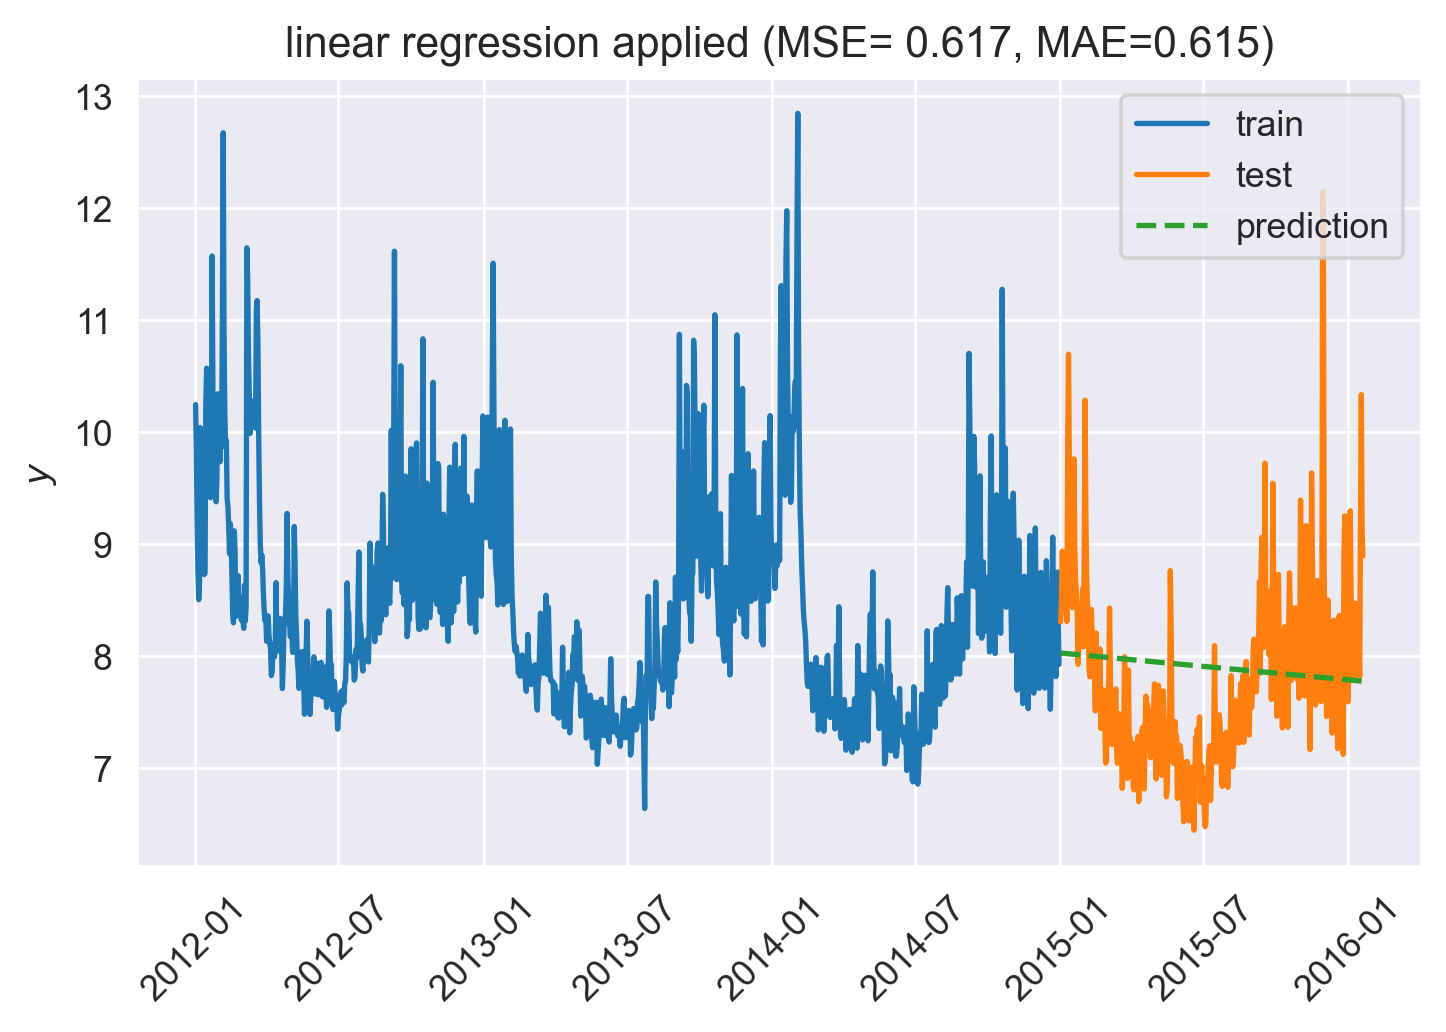

In [ ]:
# calc error metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

# visually inspect the prediction
plt.plot_date(
    x=df_train["ds"],
    y=df_train["y"],
    label="train",
    fmt="-",
)
plt.plot_date(
    x=df_test["ds"],
    y=df_test["y"],
    label="test",
    fmt="-",
)

plt.plot_date(
    x=df_test["ds"],
    y=y_pred,
    label="prediction",
    fmt="--",
)

plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("$y$")
plt.title(f"linear regression applied (MSE= {mse:.3}, MAE={mae:.3})")
plt.show()

The model is just a boring staight line, but what did you expect with a linear model(?!). The green line is passing through the orange blob, and intuitively it kinda move in the right direction. however it doesn't capture the seasonality or other patterns of the train set. 

In [ ]:
# | echo: false
print(f"mean squared error = {mse:.3}")
print(f"mean absolute error = {mae:.3}")

mean squared error = 0.617
mean absolute error = 0.615


## adding dummies

Lets add some dummies for the months and see if we can improve the performance of the model visually and on the metrics. For each month we create a column that can either have the value of `0` or `1`. if the value is `1` then that row corresponds to that particular month, in this way we are actively encoding this knowledge into the model. in this way the model can learn the magnitude and direction of each month and apply that to future predictions. at least that is the idea, lets test that!

In [ ]:
# creating dummies for the months
df_dummies = df_in.assign(
    month=df_in["ds"].dt.month.astype("category"), ds_int=df_in["ds"].astype(int)
)

not_dummy = {"y", "ds", "ds_int"}
to_dummy = set(df_dummies.columns) - not_dummy

df_dummies = pd.get_dummies(data=df_dummies, columns=["month"])
all_features = list(set(df_dummies.columns) - {"y", "ds"})

# slicing the input in train test
df_train_dummies = df_dummies[(df_dummies["ds"] > "2012") & (df_dummies["ds"] < "2015")]
df_test_dummies = df_dummies[(df_dummies["ds"] > "2015")]

X_train = df_train_dummies.loc[:, all_features]
y_train = df_train_dummies[["y"]]

X_test = df_test_dummies.loc[:, all_features]
y_test = df_test_dummies[["y"]]

df_dummies.drop(columns="ds_int").sample(n=5, random_state=1234567)

# create the pipeline
pipeline = make_pipeline(StandardScaler(), LinearRegression())
pipeline.fit(X=X_train, y=y_train)
y_pred_dummies = pipeline.predict(X=X_test)

In the code block above we are adding the dummies for the month to the data and passing that data to the linear model. plotting the results 

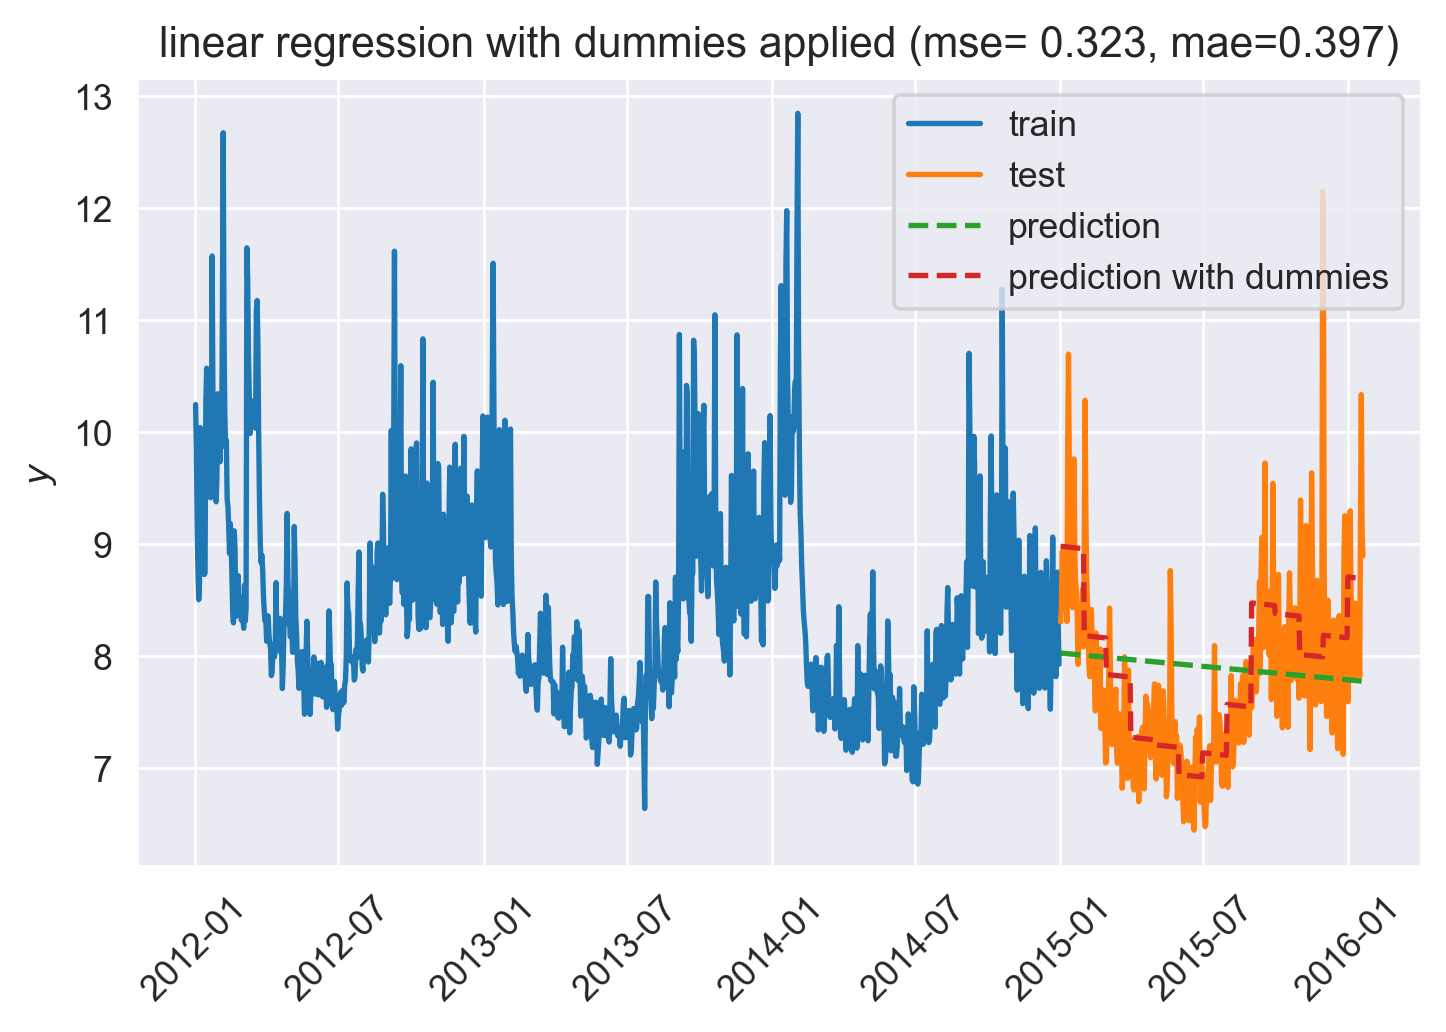

In [ ]:
mse_dummies = mean_squared_error(y_test, y_pred_dummies)
mae_dummies = mean_absolute_error(y_test, y_pred_dummies)

plt.plot_date(
    x=df_train["ds"],
    y=df_train["y"],
    label="train",
    fmt="-",
)
plt.plot_date(
    x=df_test["ds"],
    y=df_test["y"],
    label="test",
    fmt="-",
)

plt.plot_date(
    x=df_test["ds"],
    y=y_pred,
    label="prediction",
    fmt="--",
)


plt.plot_date(
    x=df_test["ds"],
    y=y_pred_dummies,
    label="prediction with dummies",
    fmt="--",
)


plt.legend(loc="upper right")
plt.tick_params(axis="x", rotation=45)
plt.ylabel("$y$")
plt.title(
    f"linear regression with dummies applied (mse= {mse_dummies:.3}, mae={mae_dummies:.3})"
)
plt.show()

In [ ]:

print(f"mean squared error = {mse_dummies:.3}")
print(f"mean absolute error = {mae_dummies:.3}")

mean squared error = 0.323
mean absolute error = 0.397


## Inspecting the seasonality

In [ ]:
# pull coefs into a seperate df, to plot the influence of time
lin_reg_coefs = (
    pd.DataFrame(data=pipeline["linearregression"].coef_, columns=X_train.columns)
    .T.reset_index()
    .rename(columns={"index": "month", 0: "coefficient"})
)
# exclude the time col
lin_reg_coefs = lin_reg_coefs[lin_reg_coefs["month"] != "ds_int"]

# centering and scaling
lin_reg_coefs["coefficient"] = (
    lin_reg_coefs["coefficient"] - lin_reg_coefs["coefficient"].mean()
) / lin_reg_coefs["coefficient"].mean()

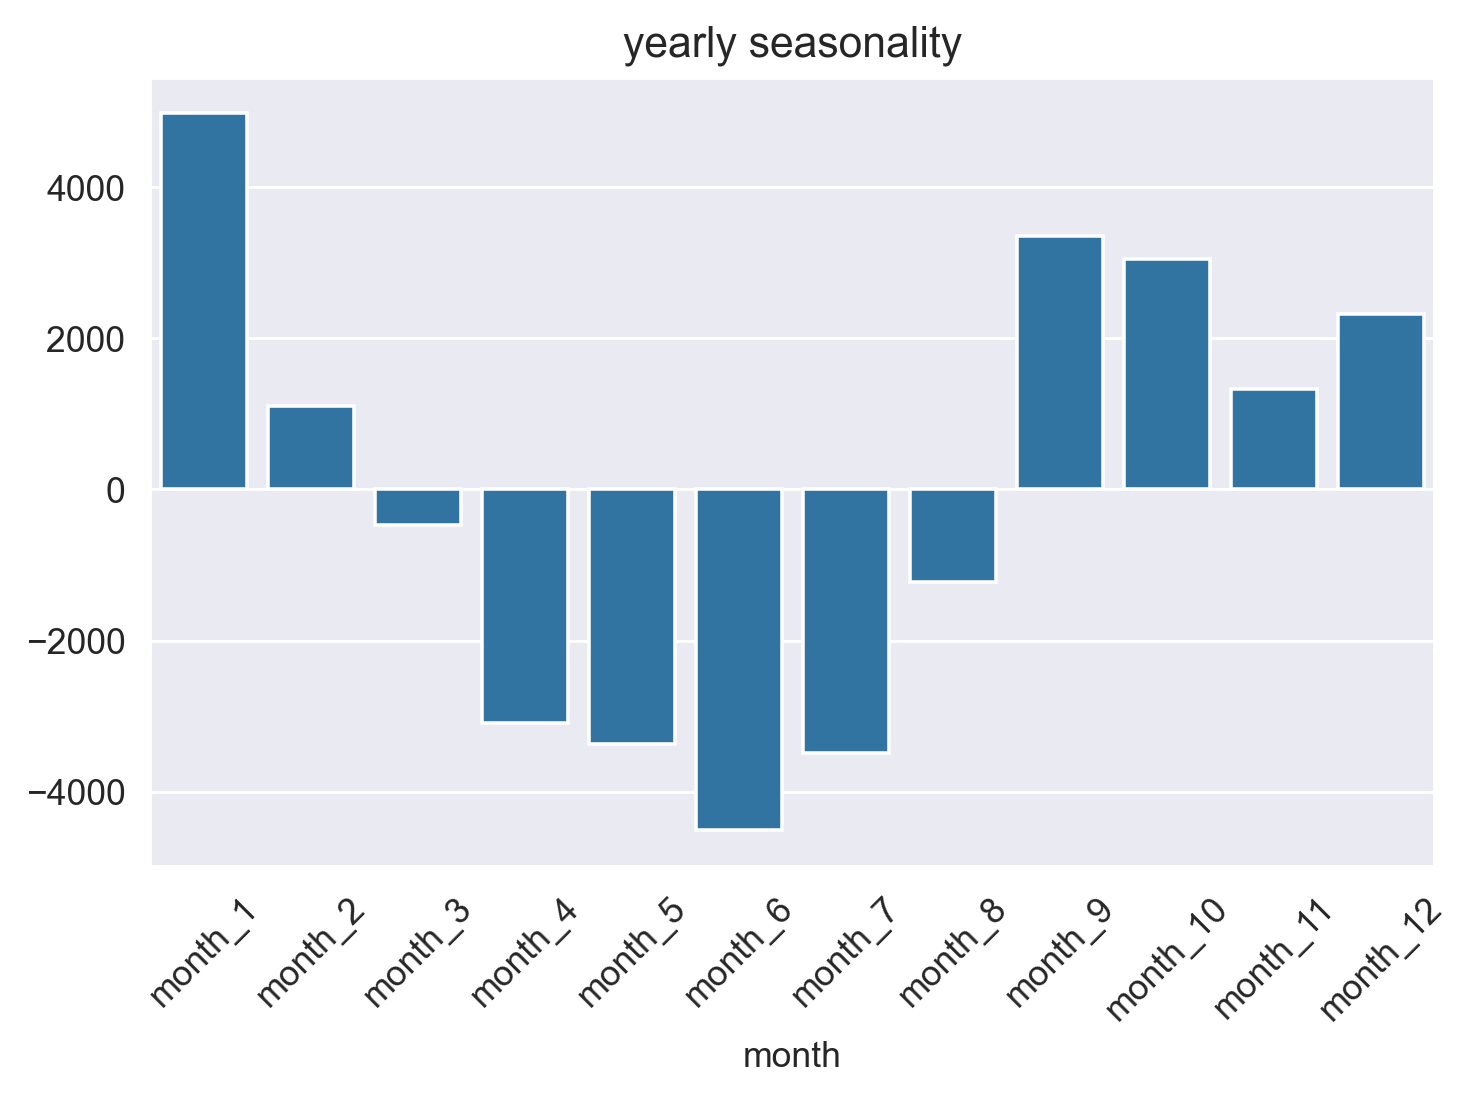

In [ ]:
# | fig-cap: seasonality over the months aka yearly seasonality


chart = sns.barplot(
    data=lin_reg_coefs,
    x="month",
    y="coefficient",
    color=sns.color_palette()[0],
    order=[
        "month_1",
        "month_2",
        "month_3",
        "month_4",
        "month_5",
        "month_6",
        "month_7",
        "month_8",
        "month_9",
        "month_10",
        "month_11",
        "month_12",
    ],
)
plt.tick_params(axis="x", rotation=45)
plt.ylabel("")
plt.title("yearly seasonality")
plt.show()

In [ ]:
# | echo: false
# | output: false
import gif

In [ ]:
# | echo: false
# | output: false

# setting mpl params
fig_height = 2.0
fig_width = fig_height * 1.618
# plt.rcParams["figure.figsize"] = [fig_width, fig_height]
# plt.rcParams["figure.dpi"] = 100

with plt.rc_context({"figure.figsize": [fig_width, fig_height], "figure.dpi": 100}):
    # create on frame of the blend between linear and dummie regression lines
    @gif.frame
    def create_blend_gif(ratio):
        y_blend = (ratio * y_pred).reshape(-1, 1) + (1 - ratio) * y_pred_dummies
        with sns.axes_style("whitegrid"):
            plt.ylim(y_pred_dummies.min(), y_pred_dummies.max())
            plt.plot_date(
                x=df_test["ds"],
                y=y_blend,
                fmt="-",
            )
            ax = plt.gca()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    # loop over all frames
    num_of_frames = 66
    gif_frames = [
        create_blend_gif(i) for i in np.linspace(start=0, stop=1, num=num_of_frames)
    ]

    # freeze on the bounce point
    gif_frames.extend([gif_frames[-1] for _ in range(num_of_frames // 6)])

    # add the the original series in reverse
    gif_frames.extend(gif_frames[::-1])

    # export the gif
    gif.save(
        gif_frames,
        "artifacts/ratio.gif",
        # duration=0.1, # seconds
    )